## 1. Setup

In [ ]:
import warnings

import pandas as pd
import numpy as np
from scipy.stats import f_oneway
import seaborn as sns

import utils.plot as plot

In [160]:
warnings.filterwarnings(
    action="ignore", category=RuntimeWarning, module="pandas.io.formats.format"
)
sns.set_theme(style="whitegrid")

In [10]:
TRAIN_PATH = "data/fraudTrain.csv"
TEST_PATH = "data/fraudTest.csv"

train_df = pd.read_csv(TRAIN_PATH)
test_df = pd.read_csv(TEST_PATH)

## 2. Data Overview

In [ ]:
print("Shapes:" f"\n  Train: {train_df.shape}" f"\n  Test: {test_df.shape}")

In [5]:
class_distribution_pct = train_df["is_fraud"].value_counts(normalize=True) * 100
print(f"Positive Class Distribution: {class_distribution_pct[1]:.2f}%")

Positive Class Distribution: 0.58%


In [ ]:
train_df.info()
test_df.info()

In [ ]:
train_df.head(10)

In [ ]:
train_df.describe()

## 3. Data cleaning

### 3.1. Drop unnecessary

In [11]:
del_col_unnamed = train_df.pop("Unnamed: 0")
del_col_unix_time = train_df.pop("unix_time")
del_col_trans_num = train_df.pop("trans_num")
del_col_zip = train_df.pop("zip")
del_col_first = train_df.pop("first")
del_col_last = train_df.pop("last")

### 3.2. Change types

In [ ]:
categories = [
    "merchant",
    "category",
    "street",
    "city",
    "state",
    "job",
    "gender",
]
train_df[categories] = train_df[categories].astype("category")
train_df[categories].head()

In [ ]:
train_df["trans_date_trans_time"] = pd.to_datetime(train_df["trans_date_trans_time"])
train_df["dob"] = pd.to_datetime(train_df["dob"], format="%Y-%m-%d")
train_df[["trans_date_trans_time", "dob"]].head()

In [ ]:
train_df.head()

### 3.3. Check for duplicates

In [ ]:
train_df[train_df.duplicated()].shape[0]

## 4. Unvariate Analysis

In [ ]:
cat_features = train_df.select_dtypes("category").drop(["cc_num"], axis=1).columns
dt_features = train_df.select_dtypes("datetime").columns
num_features = train_df.select_dtypes("number").drop("is_fraud", axis=1).columns

cat_features, dt_features, num_features

In [ ]:
plot.num_features(num_features, train_df)

In [ ]:
print("Cards:", train_df["cc_num"].nunique())

print("Categories:")
display(train_df[cat_features].nunique().sort_values())

print("Is unique:")
display(
    (
        (
            train_df.groupby("cc_num", observed=False)[
                ["lat", "long", "street", "city", "state"]
            ].nunique()
            == 1
        )
    ).all()
)

## 5. Bivariate Analysis

In [ ]:
plot.bi_num_features(num_features[1:], train_df, 3)

In [ ]:
plot.bi_cat_features(cat_features, train_df)

## 6. Feature Engineering

In [ ]:
train_df.head()

### 6.1. Date and time

In [ ]:
def cyclic_encoding(df: pd.DataFrame, feature: str, period: int):
    new_df = df.copy()
    new_df[f"{feature}_sin"] = np.sin(2 * np.pi * new_df[feature] / period)
    new_df[f"{feature}_cos"] = np.cos(2 * np.pi * new_df[feature] / period)
    return new_df

#### 6.1.1. Basic

In [34]:
train_df["hour"] = train_df["trans_date_trans_time"].dt.hour  # type: ignore
train_df["day_of_week"] = train_df["trans_date_trans_time"].dt.dayofweek  # type: ignore
train_df["month"] = train_df["trans_date_trans_time"].dt.month  # type: ignore

In [ ]:
train_df = cyclic_encoding(train_df, "hour", 24)
train_df = cyclic_encoding(train_df, "day_of_week", 7)
train_df = cyclic_encoding(train_df, "month", 12)

#### 6.1.2. Periods

In [18]:
train_df["is_weekend"] = train_df["day_of_week"] >= 5
train_df["is_night"] = (train_df["hour"] >= 0) & (train_df["hour"] <= 5)

#### 6.1.3. Time since ...

In [37]:
train_df["since_last_cc_num"] = train_df.groupby("cc_num", observed=True)["trans_date_trans_time"].diff().dt.seconds  # type: ignore

In [115]:
train_df["first_cc_num"] = train_df["since_last_cc_num"].isna()
train_df["since_last_cc_num"] = train_df["since_last_cc_num"].fillna(0)

In [ ]:
train_df.sort_values(["cc_num", "trans_date_trans_time"])[
    ["cc_num", "since_last_cc_num", "first_cc_num"]
].head()

In [42]:
train_df["since_last_merchant"] = train_df.groupby("merchant", observed=True)["trans_date_trans_time"].diff().dt.seconds  # type: ignore

In [116]:
train_df["first_merchant"] = train_df["since_last_merchant"].isna()
train_df["since_last_merchant"] = train_df["since_last_merchant"].fillna(0)

In [ ]:
train_df.sort_values(["merchant", "trans_date_trans_time"])[
    ["merchant", "since_last_merchant", "first_merchant"]
].head()

In [45]:
train_df["since_last_cc_num_merchant"] = train_df.groupby(["cc_num", "merchant"], observed=True)["trans_date_trans_time"].diff().dt.seconds  # type: ignore

In [117]:
train_df["first_cc_num_merchant"] = train_df["since_last_cc_num_merchant"].isna()
train_df["since_last_cc_num_merchant"] = train_df["since_last_cc_num_merchant"].fillna(
    0
)

In [ ]:
train_df.sort_values(
    [
        "cc_num",
        "merchant",
    ]
)[["cc_num", "merchant", "since_last_cc_num_merchant", "first_cc_num_merchant"]].head()

#### 6.1.4. Frequency

In [ ]:
def get_frequency(df: pd.DataFrame, window: int, unit: str):
    return (
        df.sort_values(["cc_num", "trans_date_trans_time"])
        .groupby("cc_num", observed=False)[["trans_date_trans_time", "amt"]]
        .rolling(f"{window}{unit}", on="trans_date_trans_time")
        .count()["amt"]
        .reset_index(level=0, drop=True)
        .sort_index()
    )

In [ ]:
train_df.sort_values("trans_date_trans_time", inplace=True)

train_df["frequency_1m"] = get_frequency(train_df, 1, "min")
train_df["frequency_5m"] = get_frequency(train_df, 5, "min")
train_df["frequency_1h"] = get_frequency(train_df, 1, "h")
train_df["frequency_1d"] = get_frequency(train_df, 1, "D")
train_df["frequency_7d"] = get_frequency(train_df, 7, "D")

In [ ]:
train_df[
    ["frequency_1m", "frequency_5m", "frequency_1h", "frequency_1d", "frequency_7d"]
]

### 6.2. Merchant

In [56]:
train_df["category_base"] = (
    train_df["category"].str.replace(r"_(pos|net)$", "", regex=True).astype("category")
).astype("category")

In [ ]:
train_df[["category", "category_base"]].head()

In [ ]:
channels = pd.Series(index=test_df["category"].unique(), dtype="object")

channels[:] = np.nan
channels[channels.index.str.endswith("_net")] = "net"
channels[channels.index.str.endswith("_pos")] = "pos"

channels

In [60]:
train_df["channel"] = train_df["category"].map(channels).astype("category")

In [ ]:
train_df[["category", "category_base", "channel"]].head()

### 6.3. Personality

#### 6.3.1. Age

In [58]:
train_df["age_at_trans"] = (train_df["trans_date_trans_time"] - train_df["dob"]).astype(
    "int64"
) // 10**9

In [62]:
train_df["dob"] = train_df["dob"].astype("int64") // 10**9

In [ ]:
train_df[["trans_date_trans_time", "dob", "age_at_trans"]].head()

#### 6.3.2. Location

In [64]:
train_df["dist_to_home_long"] = (train_df["merch_long"] - train_df["long"]).abs()
train_df["dist_to_home_lat"] = (train_df["merch_lat"] - train_df["lat"]).abs()

In [ ]:
train_df[
    [
        "dist_to_home_long",
        "merch_long",
        "long",
        "dist_to_home_lat",
        "merch_lat",
        "lat",
    ]
].head()

#### 6.4.3. Usual

In [70]:
def get_median(df: pd.DataFrame, target: str, group_col: str = "cc_num"):
    new_df = df.copy()

    result = (
        new_df.groupby(group_col, observed=False)[target]
        .expanding()
        .median()
        .groupby(level=0, observed=False)
        .shift()
        .droplevel(0)
    )

    return pd.Series(result, index=new_df.index)


def get_category_mode(df: pd.DataFrame, target: str, group_col: str = "cc_num"):
    new_df = df[[group_col, target]].copy()

    new_df[target] = new_df[target].astype("category")
    new_df["_cat_code"] = new_df[target].cat.codes
    codes = pd.Series(
        new_df[target].cat.categories.values,
        index=range(len(new_df[target].cat.categories)),
    )

    new_df["_cat_code_mode"] = (
        new_df.groupby(group_col, observed=False)["_cat_code"]
        .expanding()
        .apply(lambda x: x.mode().iloc[0])
        .groupby(level=0, observed=False)
        .shift()
        .droplevel(0)
    )

    return new_df["_cat_code_mode"].map(codes)

In [71]:
train_df.loc[:, "median_amt"] = get_median(train_df, "amt")
train_df.loc[:, "category_mode"] = get_category_mode(train_df, "category_base").astype(
    "category"
)

In [72]:
train_df["is_category_mode"] = train_df["category_base"] == train_df["category_mode"]

In [ ]:
train_df[
    [
        "cc_num",
        "category_base",
        "category_mode",
        "is_category_mode",
        "amt",
        "median_amt",
    ]
]

## 7. Typization

In [ ]:
train_df.head()

In [ ]:
train_df.select_dtypes("category").describe()

In [ ]:
train_df.select_dtypes("bool").describe()

In [ ]:
train_df.describe()  # numberical

In [ ]:
train_df.memory_usage().sum() / 1_048_576

In [ ]:
float16_features = [
    "amt",
    "median_amt",
    "hour_sin",
    "hour_cos",
    "day_of_week_sin",
    "day_of_week_cos",
    "month_sin",
    "month_cos",
    "dist_to_home_long",
    "dist_to_home_lat",
]
train_df[float16_features] = train_df[float16_features].astype("float16")

In [ ]:
float32_features = ["amt", "lat", "long", "merch_lat", "merch_long"]
train_df[float32_features] = train_df[float32_features].astype("float32")

In [ ]:
uint8_features = [
    "is_fraud",
    "hour",
    "day_of_week",
    "month",
    "frequency_1m",
    "frequency_5m",
    "frequency_1h",
    "frequency_1d",
    "frequency_7d",
]
train_df[uint8_features] = train_df[uint8_features].astype("uint8")

In [ ]:
uint32_features = [
    "city_pop",
    "dob",
    "since_last_cc_num",
    "since_last_merchant",
    "since_last_cc_num_merchant",
    "age_at_trans",
]
train_df[uint32_features] = train_df[uint32_features].astype("uint32")

In [206]:
uint64_features = ["cc_num"]
train_df[uint64_features] = train_df[uint64_features].astype("uint64")

In [ ]:
train_df.memory_usage().sum() / 1_048_576

## 8. Feature Importance Assessment

In [200]:
correlations = (
    train_df.select_dtypes(["number", "boolean"]).drop("cc_num", axis=1).corr()
)
correlations = correlations.corr().abs()
top_correlations = correlations["is_fraud"].sort_values(ascending=False)
correlations = correlations.reindex(
    index=top_correlations.index, columns=top_correlations.index
)

In [ ]:
correlations["is_fraud"]

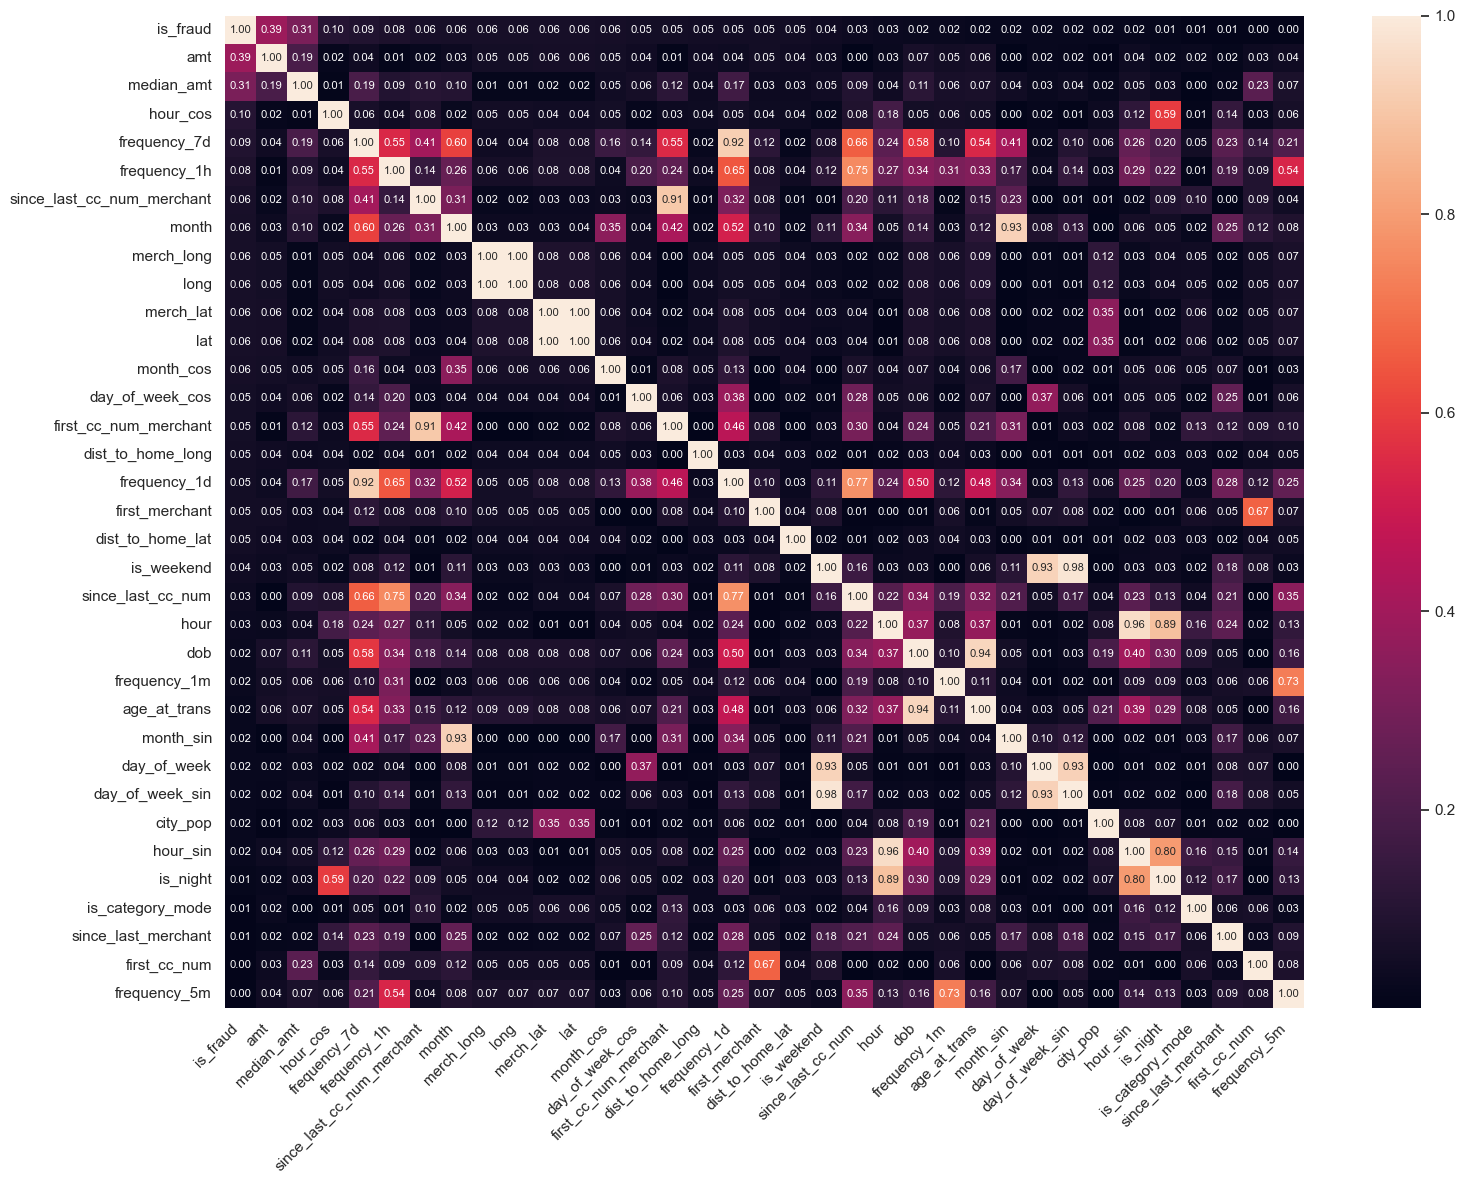

In [202]:
plot.correlation_matrix(correlations)

In [182]:
def single_anova_analysis(df: pd.DataFrame, col: str):
    groups = [
        df[df[col] == cat]["is_fraud"] for cat in df[col].unique() if cat is not np.nan
    ]
    f_stat, p_value = f_oneway(*groups)
    return f_stat, p_value


def multi_anova_analysis(df: pd.DataFrame, cols: list):
    results = []

    for col in cols:
        f_stat, p_value = single_anova_analysis(df, col)
        results.append({"feature": col, "f_stat": f_stat, "p_value": p_value})

    return pd.DataFrame(results).set_index("feature")

In [203]:
anova_results = multi_anova_analysis(train_df, list(train_df.select_dtypes("category")))

In [ ]:
anova_results.sort_values("f_stat", ascending=False)

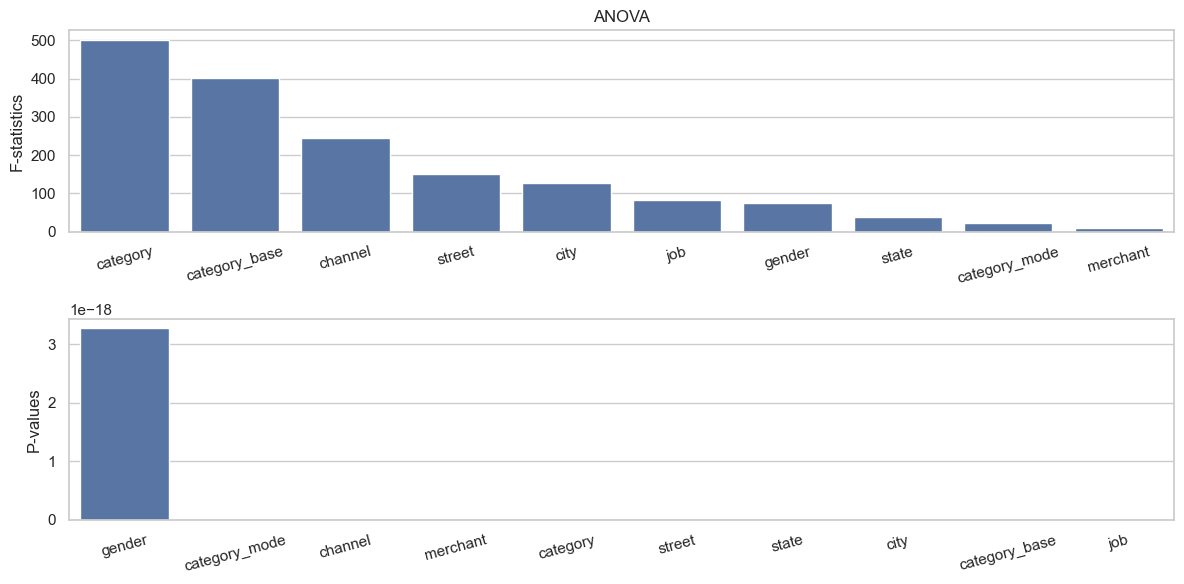

In [205]:
plot.anova(anova_results)